In [16]:
import pandas as pd

# Replace with your actual file path
df = pd.read_excel('C:/Users/Nastaran/Desktop/UniversityConstructor/semester4/Final 08042025/Data/Syllabus.xlsx')  # Make sure the columns are named 'Syllabus' and 'Course'


Step 2: Clean and Preprocess the Text

In [17]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers
    return text.strip()

df['clean_syllabus'] = df['Topic'].apply(clean_text)


Step 3: Convert Syllabi into Embeddings
 Use TF-IDF (basic, fast)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_syllabus'])


In [19]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd

# Load model & tokenizer
model_name = 'sentence-transformers/paraphrase-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_sentence_embedding(text):
    # Tokenize sentence
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    
    # Mean pooling
    embeddings = outputs.last_hidden_state
    attention_mask = inputs['attention_mask']
    mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    masked_embeddings = embeddings * mask
    summed = torch.sum(masked_embeddings, 1)
    summed_mask = torch.clamp(mask.sum(1), min=1e-9)
    mean_pooled = summed / summed_mask

    return mean_pooled.cpu().numpy()

# حالا فرض کن df یک ستون به نام 'clean_syllabus' داره
X = [get_sentence_embedding(text) for text in df['clean_syllabus']]


In [20]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd


In [21]:
model_name = 'sentence-transformers/paraphrase-MiniLM-L6-v2'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)


In [22]:
def get_sentence_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    # Mean Pooling
    embeddings = outputs.last_hidden_state
    mask = inputs['attention_mask'].unsqueeze(-1).expand(embeddings.size()).float()
    masked_embeddings = embeddings * mask
    summed = torch.sum(masked_embeddings, 1)
    summed_mask = torch.clamp(mask.sum(1), min=1e-9)
    mean_pooled = summed / summed_mask

    return mean_pooled.cpu().numpy()


In [23]:
# اگر هنوز دیتافریمت ساخته نشده:
df = pd.DataFrame({
    'clean_syllabus': [
        "Introduction to Machine Learning",
        "Deep Learning and Neural Networks",
        "Linear Algebra for AI",
        "Python Basics for Data Science",
    ]
})


In [24]:
X = [get_sentence_embedding(text) for text in df['clean_syllabus']]
X_np = torch.tensor(X).squeeze(1).numpy()  # شکل نهایی برای تشابه کسینوسی


In [25]:
similarities = cosine_similarity(X_np)


In [26]:
similarity_df = pd.DataFrame(similarities, index=df['clean_syllabus'], columns=df['clean_syllabus'])
print(similarity_df)


clean_syllabus                     Introduction to Machine Learning  \
clean_syllabus                                                        
Introduction to Machine Learning                           1.000000   
Deep Learning and Neural Networks                          0.642993   
Linear Algebra for AI                                      0.285708   
Python Basics for Data Science                             0.276903   

clean_syllabus                     Deep Learning and Neural Networks  \
clean_syllabus                                                         
Introduction to Machine Learning                            0.642993   
Deep Learning and Neural Networks                           1.000000   
Linear Algebra for AI                                       0.246133   
Python Basics for Data Science                              0.133099   

clean_syllabus                     Linear Algebra for AI  \
clean_syllabus                                             
Introduction to Mach

Step 5: Identify Similar Syllabi Between Courses


In [27]:
threshold = 0.75  # Adjust based on how strict you want the similarity to be

for i in range(len(df)):
    for j in range(i + 1, len(df)):
        sim_score = similarities[i][j]
        if sim_score > threshold:
            print(f"\n📘 Course 1: {df.iloc[i]['Course']}")
            print(f"📗 Course 2: {df.iloc[j]['Course']}")
            print(f"🔹 Similarity: {sim_score:.2f}")
            print(f"📄 Syllabus 1: {df.iloc[i]['Syllabus']}")
            print(f"📄 Syllabus 2: {df.iloc[j]['Syllabus']}")


Step 6 (Optional): Group Similar Syllabi Using Clustering


In [28]:
from sklearn.cluster import DBSCAN

# Use cosine distance for clustering
clustering = DBSCAN(eps=0.3, min_samples=2, metric='cosine').fit(X_np)
df['cluster'] = clustering.labels_

# Check grouped syllabi
for cluster_id in set(clustering.labels_):
    if cluster_id == -1:
        continue  # Ignore noise
    cluster_items = df[df['cluster'] == cluster_id]
    print(f"\n🔸 Cluster {cluster_id}:")
    for idx, row in cluster_items.iterrows():
        print(f" - ({row['Course']}) {row['Syllabus']}")


Find the Most Similar Courses to a Given One

In [29]:
import pandas as pd
import numpy as np

# Select the course you're interested in
target_course = "Deep Learning and Neural Networks"

# Find the index of that course
idx = df[df['clean_syllabus'] == target_course].index[0]

# Get similarity scores between this course and all others
similarities_to_target = similarities[idx]

# Create a DataFrame showing course names and similarity scores
similar_df = pd.DataFrame({
    'course': df['clean_syllabus'],
    'similarity': similarities_to_target
})

# Sort by similarity score (highest to lowest)
similar_df = similar_df.sort_values(by='similarity', ascending=False)

# Show the result
print(similar_df)


                              course  similarity
1  Deep Learning and Neural Networks    1.000000
0   Introduction to Machine Learning    0.642993
2              Linear Algebra for AI    0.246133
3     Python Basics for Data Science    0.133099


2. Visualize It with a Heatmap

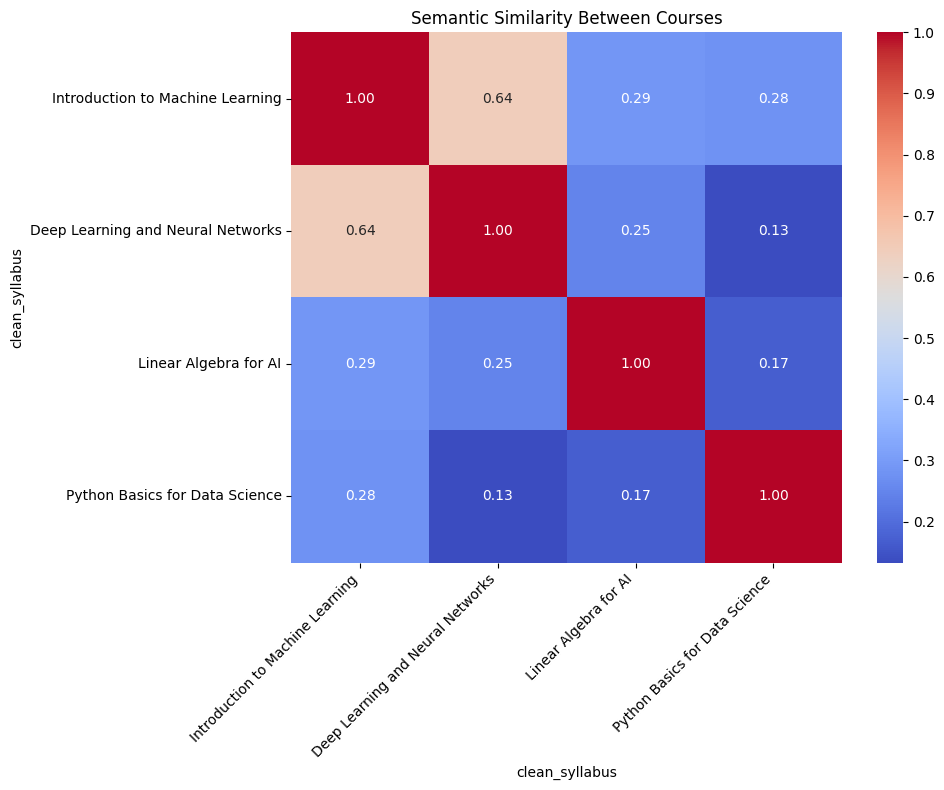

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame where rows and columns are course names
sim_df = pd.DataFrame(similarities, 
                      index=df['clean_syllabus'], 
                      columns=df['clean_syllabus'])

plt.figure(figsize=(10, 8))
sns.heatmap(sim_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Semantic Similarity Between Courses")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
